In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance

In [178]:
path = "../../Dataset/"
x_train = pd.read_csv(path + "X_train_winsorized.csv")
y_train = pd.read_csv(path + "Y_train_winsorized.csv")
x_validation = pd.read_csv(path + "X_validation.csv")
y_validation = pd.read_csv(path + "Y_validation.csv")
x_test = pd.read_csv(path + "X_test.csv")
y_test = pd.read_csv(path + "Y_test.csv")

In [179]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_validation.shape, y_validation.shape

((1084578, 47), (1084578, 1), (36537, 47), (36537, 1), (58299, 47), (58299, 1))

In [180]:
x_train.columns

Index(['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'DTDmedianNonFin', 'dummy297fin', 'day', 'StartDate', 'EventDate',
       'Duration', 'gvkey', 'tic', 'current_ratio', 'quick_ratio',
       'cash_ratio', 'net_working_capital', 'debt_ratio',
       'debt_to_equity_ratio', 'equity_ratio', 'cashflow_to_debt_ratio',
       'net_profit_margin', 'return_on_assets', 'asset_turnover',
       'inventory_turnover', 'days_in_inventory', 'receivables_turnover',
       'day_sales_outstanding', 'working_capital_turnover',
       'price_to_earnings', 'dividend_payout_ratio', 'retention_ratio',
       'gross_margin_ratio', 'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio'],
      dtype='object')

In [181]:
x_train = x_train.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])
x_test = x_test.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])
x_validation = x_validation.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])

In [182]:
x_train.head()

,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,sizetrend,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,0.089239,0.011089,0.677551,0.332808,1.411466,0.027249,-0.148249,0.079108,-5.559146,1.222586,...,197946.597222,0.000000,-5.000000,-0.000000,1.000000,-5.251700e+06,-2.189250e+07,-2.185540e+07,-149041.103448,-297211.000000
1,0.089239,0.011089,3.716702,1.502089,1.217818,0.072036,0.008587,0.003279,0.078343,0.757379,...,89.520382,0.160714,175.431034,0.000000,1.000000,4.503131e+01,-4.468629e+01,-4.203689e+01,-149041.103448,-0.776226
2,0.089239,0.011089,2.721204,0.118883,2.260250,-0.057290,0.011613,-0.010765,-1.101563,0.635338,...,339.913431,0.173655,46.875000,0.000000,1.000000,5.538300e+01,-2.503673e+01,-2.228751e+01,-0.369007,-2.958753
3,0.089239,0.011089,2.951064,-0.037748,0.603877,0.020419,0.008892,0.003140,-2.389226,-0.157686,...,536.381872,0.950565,-26.893939,-1.954545,2.954545,3.994056e+01,-6.092125e+01,-5.358098e+01,-0.604898,-0.290000
4,0.089239,0.011089,2.692160,1.016634,0.976345,0.781513,0.011998,-0.008336,-0.798139,-0.171643,...,490.664365,0.374972,178.125000,0.000000,1.000000,3.530126e+01,-6.099560e+01,-5.861284e+01,-1.081539,2.392157


In [183]:
x_validation.head()

,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,sizetrend,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,0.192826,-0.005433,6.250847,-0.735217,1.697847,-0.081757,0.002724,-0.004236,-0.568848,-0.137430,...,0.000000,0.446755,64.851064,0.000000,1.000000,63.795411,-19.901291,-16.375467,-1.932519,1.598465
1,0.105057,-0.004959,6.749736,-0.359299,0.738704,-0.043337,0.021803,-0.001543,1.745192,0.279547,...,0.000000,0.507572,69.714286,0.714286,0.285714,48.759197,-2.481606,4.202519,-0.009606,15.125725
2,0.192826,-0.005433,5.584149,0.240706,0.780843,-0.120942,0.005813,0.002473,-0.405486,-0.012954,...,0.000000,1.133384,-403.666667,-4.666667,5.666667,37.969338,-55.366431,-53.815078,-0.804776,22.197826
3,0.192826,-0.005433,3.861650,-0.868666,0.659304,-0.021310,0.000808,-0.007019,-1.596573,-0.196801,...,174.952295,3.045574,24.153846,0.192308,0.807692,50.225961,-38.556212,-35.826935,-0.322696,6.164028
4,0.192826,-0.005433,1.474048,-0.508618,0.798067,-0.206794,-0.109041,-0.137746,-1.628903,-0.515058,...,31.543210,0.004273,-10.833333,-0.000000,1.000000,55.555556,-2469.135802,-2469.135802,-19.047619,-297211.000000


In [184]:
x_test.head()

,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,sizetrend,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,0.200978,-0.010836,0.880509,-0.225261,0.846543,0.196617,0.020281,0.000324,-3.881888,-0.526272,...,46.335117,1.730432,2.103448,0.000000,1.000000,25.576709,-57.559755,-54.870762,-7.642066,1.472370
1,0.200978,-0.010836,8.703251,3.208988,-0.286914,-0.097100,0.004932,0.000167,3.403550,0.102042,...,292.697411,-1.912480,123.449275,0.536232,0.463768,39.912720,-40.608598,-37.518429,-0.127990,7.439189
2,0.200978,-0.010836,12.831392,2.522139,1.073841,-0.022397,0.006695,0.000374,1.755884,0.020167,...,203.377571,1.102599,185.015152,0.000000,1.000000,33.145258,-45.640366,-39.666969,-0.230408,8.671120
3,0.200978,-0.010836,2.643683,0.356163,0.000000,0.000000,-0.000151,-0.001490,0.805359,-0.018876,...,0.000000,-0.285732,105.529412,1.294118,-0.294118,39.733633,-36.652932,10.405404,-0.029045,1.788448
4,0.222340,-0.010290,7.464687,0.840452,-0.169661,-0.221463,0.003408,-0.000191,5.800089,-0.043411,...,33.424748,0.404898,63.370000,0.500000,0.500000,40.302448,-19.395103,-3.840614,-0.021989,3.922897


In [185]:
# mini sample to try:
msk = np.random.rand(len(x_train)) < 0.0001
x_train_sample=x_train[msk]
y_train_sample=y_train[msk]

In [186]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "precision" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'precision', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    if optimisation_metric == 'recall': 
        return recall
    elif optimisation_metric == 'precision': 
        return precision
    elif optimisation_metric == 'f1':
        return f1
    elif optimisation_metric == 'auc':
        return auc
    elif optimisation_metric == 'accuracy': 
        return accuracy
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-06 14:01:49,073] A new study created in memory with name: no-name-4f1b80af-cc6b-4414-9c80-a3d1581e7b8b


c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 14:02:10,300] Trial 0 finished with value: 0.0 and parameters: {'num_leaves': 145, 'lambda_l1': 3.0068834902530244e-08, 'lambda_l2': 5.3971667896394755e-06, 'feature_fraction': 0.687005605377518, 'min_child_samples': 81, 'learning_rate': 4.1510446994703574e-07, 'max_depth': 82, 'num_boost_round': 239}. Best is trial 0 with value: 0.0.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 14:02:34,523] Trial 1 finished with value: 0.0 and parameters: {'num_leaves': 128, 'lambda_l1': 0.00016572337258557052, 'lambda_l2': 0.045605340417501354, 'feature_fraction': 0.9332198020654849, 'min_child_samples': 74, 'learning_rate': 0.0001542231150446922, 'max_depth': 243, 'num_boost_round': 239}. Best is trial 0 with value: 0.0.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:02:42,836] Trial 2 finished with value: 0.048106904231625836 and parameters: {'num_leaves': 142, 'lambda_l1': 0.0015701321011687254, 'lambda_l2': 5.400530838988474e-08, 'feature_fraction': 0.46744420586479296, 'min_child_samples': 26, 'learning_rate': 0.1291106351450331, 'max_depth': 94, 'num_boost_round': 179}. Best is trial 2 with value: 0.048106904231625836.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

[I 2023-11-06 14:02:49,667] Trial 3 finished with value: 0.005420333110344946 and parameters: {'num_leaves': 3, 'lambda_l1': 0.33091228331753225, 'lambda_l2': 5.294962182963683e-07, 'feature_fraction': 0.6451404188509721, 'min_child_samples': 53, 'learning_rate': 7.275958778742988, 'max_depth': 166, 'num_boost_round': 343}. Best is trial 2 with value: 0.048106904231625836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:02:55,415] Trial 4 finished with value: 0.030807764558547276 and parameters: {'num_leaves': 26, 'lambda_l1': 8.431228084843537, 'lambda_l2': 0.38109526208665484, 'feature_fraction': 0.7889214526076866, 'min_child_samples': 30, 'learning_rate': 0.30932885831956985, 'max_depth': 81, 'num_boost_round': 137}. Best is trial 2 with value: 0.048106904231625836.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:03:25,926] Trial 5 finished with value: 0.3615023474178404 and parameters: {'num_leaves': 251, 'lambda_l1': 2.3086662311991362e-05, 'lambda_l2': 0.04587534471983062, 'feature_fraction': 0.4582878682337074, 'min_child_samples': 25, 'learning_rate': 0.04934689619210067, 'max_depth': 114, 'num_boost_round': 401}. Best is trial 5 with value: 0.3615023474178404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:03:33,302] Trial 6 finished with value: 0.04229607250755287 and parameters: {'num_leaves': 50, 'lambda_l1': 1.2339730621762843, 'lambda_l2': 0.19702637417661192, 'feature_fraction': 0.65367175531455, 'min_child_samples': 61, 'learning_rate': 0.2358567557603808, 'max_depth': 169, 'num_boost_round': 165}. Best is trial 5 with value: 0.3615023474178404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 14:03:53,787] Trial 7 finished with value: 0.0 and parameters: {'num_leaves': 112, 'lambda_l1': 0.04092467948157377, 'lambda_l2': 0.022864912449237412, 'feature_fraction': 0.40993640088476563, 'min_child_samples': 88, 'learning_rate': 1.2727121028402912e-07, 'max_depth': 26, 'num_boost_round': 336}. Best is trial 5 with value: 0.3615023474178404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 14:04:53,889] Trial 8 finished with value: 0.0 and parameters: {'num_leaves': 164, 'lambda_l1': 0.024692435076774672, 'lambda_l2': 2.3258320852739115e-05, 'feature_fraction': 0.9916654257840671, 'min_child_samples': 55, 'learning_rate': 5.300519625267243e-05, 'max_depth': 239, 'num_boost_round': 379}. Best is trial 5 with value: 0.3615023474178404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:05:22,598] Trial 9 finished with value: 0.28171641791044777 and parameters: {'num_leaves': 254, 'lambda_l1': 5.789713235780841, 'lambda_l2': 0.023792774196639433, 'feature_fraction': 0.5785377336053187, 'min_child_samples': 47, 'learning_rate': 0.06069147312293722, 'max_depth': 182, 'num_boost_round': 221}. Best is trial 5 with value: 0.3615023474178404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-06 14:05:54,264] Trial 10 finished with value: 0.0657094183499635 and parameters: {'num_leaves': 255, 'lambda_l1': 5.196806916009872e-06, 'lambda_l2': 0.0004502300828948939, 'feature_fraction': 0.5081825626683585, 'min_child_samples': 9, 'learning_rate': 0.003065907899992048, 'max_depth': 6, 'num_boost_round': 499}. Best is trial 5 with value: 0.3615023474178404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:06:48,974] Trial 11 finished with value: 0.10711331679073614 and parameters: {'num_leaves': 246, 'lambda_l1': 4.7560500752403565e-05, 'lambda_l2': 8.600714720600791, 'feature_fraction': 0.5394324267768246, 'min_child_samples': 33, 'learning_rate': 0.008540509672844877, 'max_depth': 186, 'num_boost_round': 443}. Best is trial 5 with value: 0.3615023474178404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2023-11-06 14:06:57,945] Trial 12 finished with value: 0.02757393818100956 and parameters: {'num_leaves': 204, 'lambda_l1': 0.002805984600185536, 'lambda_l2': 0.0018746204949189028, 'feature_fraction': 0.5724337897632512, 'min_child_samples': 6, 'learning_rate': 7.002689658220926, 'max_depth': 131, 'num_boost_round': 262}. Best is trial 5 with value: 0.3615023474178404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:07:36,673] Trial 13 finished with value: 0.09255242227042661 and parameters: {'num_leaves': 208, 'lambda_l1': 4.981404650761671e-06, 'lambda_l2': 0.004546039268539327, 'feature_fraction': 0.4284830684422808, 'min_child_samples': 42, 'learning_rate': 0.00480181679513728, 'max_depth': 210, 'num_boost_round': 413}. Best is trial 5 with value: 0.3615023474178404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 14:08:05,407] Trial 14 finished with value: 0.0 and parameters: {'num_leaves': 212, 'lambda_l1': 9.859988526726742, 'lambda_l2': 0.00023796407184989497, 'feature_fraction': 0.579839724141607, 'min_child_samples': 19, 'learning_rate': 1.3132950539847075e-05, 'max_depth': 127, 'num_boost_round': 293}. Best is trial 5 with value: 0.3615023474178404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:08:14,172] Trial 15 finished with value: 0.07260351673284175 and parameters: {'num_leaves': 88, 'lambda_l1': 0.03844746688364663, 'lambda_l2': 0.9204516525147033, 'feature_fraction': 0.49937405406858837, 'min_child_samples': 40, 'learning_rate': 0.013556649279759456, 'max_depth': 125, 'num_boost_round': 107}. Best is trial 5 with value: 0.3615023474178404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 14:08:56,623] Trial 16 finished with value: 0.0 and parameters: {'num_leaves': 180, 'lambda_l1': 0.001725428002131555, 'lambda_l2': 0.016344816255332965, 'feature_fraction': 0.45771240482383657, 'min_child_samples': 69, 'learning_rate': 0.0004110736404112786, 'max_depth': 49, 'num_boost_round': 470}. Best is trial 5 with value: 0.3615023474178404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:09:35,171] Trial 17 finished with value: 0.41580756013745707 and parameters: {'num_leaves': 232, 'lambda_l1': 0.625640774785974, 'lambda_l2': 9.267113749563977, 'feature_fraction': 0.5778178061349185, 'min_child_samples': 42, 'learning_rate': 0.0886471621298649, 'max_depth': 155, 'num_boost_round': 388}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 14:10:06,796] Trial 18 finished with value: 0.0 and parameters: {'num_leaves': 221, 'lambda_l1': 0.22959613967259446, 'lambda_l2': 7.650236200287283, 'feature_fraction': 0.40881369682225494, 'min_child_samples': 98, 'learning_rate': 0.0007594426033165375, 'max_depth': 139, 'num_boost_round': 386}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-06 14:10:26,159] Trial 19 finished with value: 0.03905526397036122 and parameters: {'num_leaves': 183, 'lambda_l1': 1.990351599808202e-05, 'lambda_l2': 1.4697824668703805, 'feature_fraction': 0.744843606325829, 'min_child_samples': 16, 'learning_rate': 1.2015268890927489, 'max_depth': 99, 'num_boost_round': 334}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:11:05,061] Trial 20 finished with value: 0.2869718309859155 and parameters: {'num_leaves': 231, 'lambda_l1': 2.5901863104436887e-07, 'lambda_l2': 0.18031393757031583, 'feature_fraction': 0.48567435865357506, 'min_child_samples': 21, 'learning_rate': 0.03470246526749728, 'max_depth': 56, 'num_boost_round': 428}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:11:45,310] Trial 21 finished with value: 0.2096069868995633 and parameters: {'num_leaves': 229, 'lambda_l1': 3.634376514391037e-07, 'lambda_l2': 0.16897708091953922, 'feature_fraction': 0.4950165840589191, 'min_child_samples': 22, 'learning_rate': 0.023455691465796735, 'max_depth': 59, 'num_boost_round': 423}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-06 14:12:13,864] Trial 22 finished with value: 0.060733613950691524 and parameters: {'num_leaves': 233, 'lambda_l1': 9.934174257050087e-07, 'lambda_l2': 2.188470429537449, 'feature_fraction': 0.5397780907872087, 'min_child_samples': 33, 'learning_rate': 0.8142091414634905, 'max_depth': 61, 'num_boost_round': 379}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:12:50,748] Trial 23 finished with value: 0.40168539325842695 and parameters: {'num_leaves': 196, 'lambda_l1': 1.9899447192476103e-08, 'lambda_l2': 0.207407170914815, 'feature_fraction': 0.4610130086761018, 'min_child_samples': 15, 'learning_rate': 0.06207871509594321, 'max_depth': 151, 'num_boost_round': 461}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:13:25,916] Trial 24 finished with value: 0.3924050632911392 and parameters: {'num_leaves': 184, 'lambda_l1': 3.855623541586257e-08, 'lambda_l2': 9.265963815754331, 'feature_fraction': 0.4525804578171505, 'min_child_samples': 13, 'learning_rate': 0.08173990429807033, 'max_depth': 143, 'num_boost_round': 478}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:14:10,695] Trial 25 finished with value: 0.15085714285714286 and parameters: {'num_leaves': 185, 'lambda_l1': 1.5054251843929155e-08, 'lambda_l2': 8.964699233420015, 'feature_fraction': 0.4012673168438569, 'min_child_samples': 14, 'learning_rate': 1.1025883865188886, 'max_depth': 152, 'num_boost_round': 495}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:14:58,456] Trial 26 finished with value: 0.11116300794021486 and parameters: {'num_leaves': 165, 'lambda_l1': 1.0270803342169833e-08, 'lambda_l2': 1.6039830882263388, 'feature_fraction': 0.6058173772082927, 'min_child_samples': 5, 'learning_rate': 0.002742039188534895, 'max_depth': 207, 'num_boost_round': 458}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:15:32,826] Trial 27 finished with value: 0.14446952595936793 and parameters: {'num_leaves': 195, 'lambda_l1': 3.843568043546884e-08, 'lambda_l2': 0.7962446295088632, 'feature_fraction': 0.5190570930621052, 'min_child_samples': 40, 'learning_rate': 0.11571436905691992, 'max_depth': 152, 'num_boost_round': 471}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.200678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:16:09,353] Trial 28 finished with value: 0.13104611923509563 and parameters: {'num_leaves': 160, 'lambda_l1': 1.0873028919696531e-07, 'lambda_l2': 3.2485228134847812, 'feature_fraction': 0.4552046773924849, 'min_child_samples': 13, 'learning_rate': 0.018032536287821338, 'max_depth': 201, 'num_boost_round': 449}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 14:16:40,334] Trial 29 finished with value: 0.0 and parameters: {'num_leaves': 109, 'lambda_l1': 5.907954946111812e-08, 'lambda_l2': 9.348042723302733, 'feature_fraction': 0.5555604936787341, 'min_child_samples': 64, 'learning_rate': 0.0016249216119266084, 'max_depth': 149, 'num_boost_round': 357}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:17:24,304] Trial 30 finished with value: 0.10953769262807164 and parameters: {'num_leaves': 193, 'lambda_l1': 6.580227387256896e-07, 'lambda_l2': 0.5437373927093935, 'feature_fraction': 0.5282605302097365, 'min_child_samples': 46, 'learning_rate': 0.009870045046807512, 'max_depth': 107, 'num_boost_round': 484}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:17:53,300] Trial 31 finished with value: 0.4122137404580153 and parameters: {'num_leaves': 234, 'lambda_l1': 9.705173821015595e-08, 'lambda_l2': 0.11174000924407154, 'feature_fraction': 0.449301844747978, 'min_child_samples': 27, 'learning_rate': 0.09045293202422497, 'max_depth': 115, 'num_boost_round': 404}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-06 14:18:07,926] Trial 32 finished with value: 0.03814449652497171 and parameters: {'num_leaves': 217, 'lambda_l1': 7.447995733439535e-08, 'lambda_l2': 0.08944519892466829, 'feature_fraction': 0.4491264674393156, 'min_child_samples': 29, 'learning_rate': 0.5147591917588539, 'max_depth': 167, 'num_boost_round': 436}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:18:26,407] Trial 33 finished with value: 0.12283236994219653 and parameters: {'num_leaves': 144, 'lambda_l1': 2.2459478060306807e-08, 'lambda_l2': 0.6129862796835296, 'feature_fraction': 0.4339909301626245, 'min_child_samples': 36, 'learning_rate': 0.1327346248482638, 'max_depth': 118, 'num_boost_round': 406}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:18:49,189] Trial 34 finished with value: 0.24607329842931938 and parameters: {'num_leaves': 172, 'lambda_l1': 1.658561532478262e-07, 'lambda_l2': 2.713831027500191, 'feature_fraction': 0.48074616686658206, 'min_child_samples': 11, 'learning_rate': 0.05448828094907125, 'max_depth': 93, 'num_boost_round': 311}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] St

[I 2023-11-06 14:18:59,204] Trial 35 finished with value: 0.00807397143466212 and parameters: {'num_leaves': 207, 'lambda_l1': 1.0925889210042336e-08, 'lambda_l2': 0.10112081969030393, 'feature_fraction': 0.48304988407611715, 'min_child_samples': 27, 'learning_rate': 2.4917968760800995, 'max_depth': 80, 'num_boost_round': 364}. Best is trial 17 with value: 0.41580756013745707.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:19:31,285] Trial 36 finished with value: 0.1206896551724138 and parameters: {'num_leaves': 238, 'lambda_l1': 1.4386970589197014e-06, 'lambda_l2': 0.37847401512193807, 'feature_fraction': 0.4333556376235192, 'min_child_samples': 21, 'learning_rate': 0.27614480772079275, 'max_depth': 142, 'num_boost_round': 466}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:19:52,623] Trial 37 finished with value: 0.1146551724137931 and parameters: {'num_leaves': 134, 'lambda_l1': 5.8040521246939445e-08, 'lambda_l2': 2.874681770487019, 'feature_fraction': 0.6085401623589519, 'min_child_samples': 16, 'learning_rate': 0.17009424304700752, 'max_depth': 178, 'num_boost_round': 397}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] St

[I 2023-11-06 14:20:04,227] Trial 38 finished with value: 0.006654146669448888 and parameters: {'num_leaves': 155, 'lambda_l1': 0.00047432878768326664, 'lambda_l2': 0.36938155775388853, 'feature_fraction': 0.5075890794576212, 'min_child_samples': 25, 'learning_rate': 3.22903165879383, 'max_depth': 159, 'num_boost_round': 442}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2023-11-06 14:20:19,150] Trial 39 finished with value: 0.005684474279623777 and parameters: {'num_leaves': 223, 'lambda_l1': 1.8664488692936494e-07, 'lambda_l2': 0.06235272463503857, 'feature_fraction': 0.46452919367726203, 'min_child_samples': 51, 'learning_rate': 0.42375483033289146, 'max_depth': 225, 'num_boost_round': 308}. Best is trial 17 with value: 0.41580756013745707.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:20:58,070] Trial 40 finished with value: 0.448 and parameters: {'num_leaves': 195, 'lambda_l1': 4.1292626846437454e-08, 'lambda_l2': 2.8378054507386485, 'feature_fraction': 0.6628194125066171, 'min_child_samples': 34, 'learning_rate': 0.08592934609686223, 'max_depth': 193, 'num_boost_round': 479}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:21:36,045] Trial 41 finished with value: 0.41785714285714287 and parameters: {'num_leaves': 196, 'lambda_l1': 5.89498282743074e-08, 'lambda_l2': 3.1150693390539397, 'feature_fraction': 0.6619721165771222, 'min_child_samples': 35, 'learning_rate': 0.07731728508712257, 'max_depth': 192, 'num_boost_round': 479}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:22:17,245] Trial 42 finished with value: 0.22676579925650558 and parameters: {'num_leaves': 197, 'lambda_l1': 1.3234555303357187e-07, 'lambda_l2': 0.21174657355086474, 'feature_fraction': 0.6724716161769964, 'min_child_samples': 36, 'learning_rate': 0.030981684701487856, 'max_depth': 189, 'num_boost_round': 420}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:22:58,205] Trial 43 finished with value: 0.16379310344827586 and parameters: {'num_leaves': 239, 'lambda_l1': 3.38467693222637e-08, 'lambda_l2': 1.2965679834224246, 'feature_fraction': 0.7063362808557511, 'min_child_samples': 45, 'learning_rate': 0.19531280532477172, 'max_depth': 227, 'num_boost_round': 499}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:23:25,916] Trial 44 finished with value: 0.062075016450976093 and parameters: {'num_leaves': 68, 'lambda_l1': 4.887513368621074e-07, 'lambda_l2': 0.5077403015033933, 'feature_fraction': 0.6362997105404746, 'min_child_samples': 54, 'learning_rate': 0.007479728454678661, 'max_depth': 253, 'num_boost_round': 448}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:24:02,154] Trial 45 finished with value: 0.4254658385093168 and parameters: {'num_leaves': 244, 'lambda_l1': 1.6130347861634511e-06, 'lambda_l2': 3.977001284250476, 'feature_fraction': 0.7044859973721758, 'min_child_samples': 36, 'learning_rate': 0.061447199146933563, 'max_depth': 192, 'num_boost_round': 397}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:24:30,670] Trial 46 finished with value: 0.11578947368421053 and parameters: {'num_leaves': 249, 'lambda_l1': 1.3414637828941349e-06, 'lambda_l2': 4.0629623787653815, 'feature_fraction': 0.690066105956279, 'min_child_samples': 33, 'learning_rate': 0.3347836593770123, 'max_depth': 175, 'num_boost_round': 353}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:25:10,781] Trial 47 finished with value: 0.3793969849246231 and parameters: {'num_leaves': 244, 'lambda_l1': 2.9009804729598642e-06, 'lambda_l2': 3.6442443453399895, 'feature_fraction': 0.7160266863635001, 'min_child_samples': 37, 'learning_rate': 0.04983077063019437, 'max_depth': 222, 'num_boost_round': 393}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:25:45,948] Trial 48 finished with value: 0.11587147030185005 and parameters: {'num_leaves': 222, 'lambda_l1': 2.997446214886852e-07, 'lambda_l2': 1.4509912598190857, 'feature_fraction': 0.6511539974799467, 'min_child_samples': 50, 'learning_rate': 0.01740693232855191, 'max_depth': 194, 'num_boost_round': 277}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:26:32,802] Trial 49 finished with value: 0.11687087653157399 and parameters: {'num_leaves': 256, 'lambda_l1': 1.2500995521844945e-05, 'lambda_l2': 1.3504451584718786, 'feature_fraction': 0.7663370068375337, 'min_child_samples': 61, 'learning_rate': 0.00567742613340892, 'max_depth': 214, 'num_boost_round': 322}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:26:49,062] Trial 50 finished with value: 0.11093161012385568 and parameters: {'num_leaves': 30, 'lambda_l1': 5.631854932840958e-05, 'lambda_l2': 0.040484779058586266, 'feature_fraction': 0.6248982372252805, 'min_child_samples': 42, 'learning_rate': 0.10828845108885053, 'max_depth': 199, 'num_boost_round': 377}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:27:08,711] Trial 51 finished with value: 0.23770491803278687 and parameters: {'num_leaves': 207, 'lambda_l1': 2.055782724306802e-08, 'lambda_l2': 3.4676266661264807, 'feature_fraction': 0.6795515218250457, 'min_child_samples': 30, 'learning_rate': 0.0687740361740183, 'max_depth': 166, 'num_boost_round': 201}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:27:53,421] Trial 52 finished with value: 0.22934648581997533 and parameters: {'num_leaves': 199, 'lambda_l1': 8.043289918395329e-08, 'lambda_l2': 0.6876566821275292, 'feature_fraction': 0.6675401047662813, 'min_child_samples': 24, 'learning_rate': 0.028327224755371912, 'max_depth': 182, 'num_boost_round': 459}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-06 14:28:16,108] Trial 53 finished with value: 0.039290048543689324 and parameters: {'num_leaves': 215, 'lambda_l1': 5.497201302308895e-07, 'lambda_l2': 0.2664744484523752, 'feature_fraction': 0.5897052670417853, 'min_child_samples': 31, 'learning_rate': 0.6602186288529633, 'max_depth': 173, 'num_boost_round': 412}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:28:56,760] Trial 54 finished with value: 0.16200294550810015 and parameters: {'num_leaves': 228, 'lambda_l1': 1.6261009920193952e-07, 'lambda_l2': 4.956813327493782, 'feature_fraction': 0.5633697013049265, 'min_child_samples': 38, 'learning_rate': 0.23436106489918035, 'max_depth': 241, 'num_boost_round': 487}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:29:41,680] Trial 55 finished with value: 0.12672322375397668 and parameters: {'num_leaves': 176, 'lambda_l1': 2.529573592147469e-08, 'lambda_l2': 0.0109545881042101, 'feature_fraction': 0.6475349876501514, 'min_child_samples': 43, 'learning_rate': 0.01452639241325839, 'max_depth': 133, 'num_boost_round': 429}. Best is trial 40 with value: 0.448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:30:31,008] Trial 56 finished with value: 0.4715447154471545 and parameters: {'num_leaves': 238, 'lambda_l1': 3.0219337365784373e-07, 'lambda_l2': 0.14744482237454176, 'feature_fraction': 0.8212132523715935, 'min_child_samples': 28, 'learning_rate': 0.056686008229241705, 'max_depth': 158, 'num_boost_round': 479}. Best is trial 56 with value: 0.4715447154471545.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No

[I 2023-11-06 14:30:48,087] Trial 57 finished with value: 0.1875 and parameters: {'num_leaves': 240, 'lambda_l1': 2.089471729911977e-06, 'lambda_l2': 0.04131015608221058, 'feature_fraction': 0.8474956334260486, 'min_child_samples': 28, 'learning_rate': 1.7367433420093263, 'max_depth': 160, 'num_boost_round': 480}. Best is trial 56 with value: 0.4715447154471545.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:31:27,750] Trial 58 finished with value: 0.13690105787181084 and parameters: {'num_leaves': 247, 'lambda_l1': 9.187476079794948e-07, 'lambda_l2': 0.10941873899765356, 'feature_fraction': 0.7213445459724587, 'min_child_samples': 81, 'learning_rate': 0.0035383586243457887, 'max_depth': 195, 'num_boost_round': 338}. Best is trial 56 with value: 0.4715447154471545.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-06 14:32:13,952] Trial 59 finished with value: 0.07998408276959809 and parameters: {'num_leaves': 232, 'lambda_l1': 3.0726842081169707e-07, 'lambda_l2': 1.172617862248507, 'feature_fraction': 0.8143802793255439, 'min_child_samples': 49, 'learning_rate': 0.573549063478647, 'max_depth': 114, 'num_boost_round': 403}. Best is trial 56 with value: 0.4715447154471545.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-06 14:32:26,029] Trial 60 finished with value: 0.0 and parameters: {'num_leaves': 210, 'lambda_l1': 3.6104868898574127e-06, 'lambda_l2': 6.704512073492353, 'feature_fraction': 0.6634338786249898, 'min_child_samples': 34, 'learning_rate': 6.0922234722252595, 'max_depth': 186, 'num_boost_round': 371}. Best is trial 56 with value: 0.4715447154471545.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:33:02,706] Trial 61 finished with value: 0.2754158964879852 and parameters: {'num_leaves': 191, 'lambda_l1': 5.379744648826725e-08, 'lambda_l2': 0.2380544286229505, 'feature_fraction': 0.6256704461816356, 'min_child_samples': 17, 'learning_rate': 0.041062742997201904, 'max_depth': 160, 'num_boost_round': 451}. Best is trial 56 with value: 0.4715447154471545.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:33:51,115] Trial 62 finished with value: 0.5294117647058824 and parameters: {'num_leaves': 256, 'lambda_l1': 9.163401322905765e-08, 'lambda_l2': 2.1087408160736305, 'feature_fraction': 0.6876518282761398, 'min_child_samples': 23, 'learning_rate': 0.08716025095153894, 'max_depth': 125, 'num_boost_round': 500}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:34:46,518] Trial 63 finished with value: 0.4666666666666667 and parameters: {'num_leaves': 254, 'lambda_l1': 2.52733756516016e-07, 'lambda_l2': 4.330255468193948, 'feature_fraction': 0.7274903710079682, 'min_child_samples': 24, 'learning_rate': 0.09959414458442963, 'max_depth': 123, 'num_boost_round': 500}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:35:28,005] Trial 64 finished with value: 0.1379800853485064 and parameters: {'num_leaves': 256, 'lambda_l1': 3.8044217190228726e-07, 'lambda_l2': 2.5792908480911008, 'feature_fraction': 0.6931366627328452, 'min_child_samples': 22, 'learning_rate': 0.21276559198439457, 'max_depth': 126, 'num_boost_round': 489}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:36:25,117] Trial 65 finished with value: 0.2154006243496358 and parameters: {'num_leaves': 244, 'lambda_l1': 9.02622126764148e-06, 'lambda_l2': 9.824551639098349, 'feature_fraction': 0.7336913534663756, 'min_child_samples': 40, 'learning_rate': 0.01935848985030618, 'max_depth': 136, 'num_boost_round': 500}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:37:18,541] Trial 66 finished with value: 0.11215791834903545 and parameters: {'num_leaves': 225, 'lambda_l1': 6.962925078509088e-07, 'lambda_l2': 5.105802430901542, 'feature_fraction': 0.6985477800593631, 'min_child_samples': 19, 'learning_rate': 0.008407254934098713, 'max_depth': 204, 'num_boost_round': 479}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-06 14:37:47,607] Trial 67 finished with value: 0.05528031290743155 and parameters: {'num_leaves': 248, 'lambda_l1': 1.8352452987598826, 'lambda_l2': 1.893888462958104, 'feature_fraction': 0.6785154899319451, 'min_child_samples': 32, 'learning_rate': 0.9350892920401116, 'max_depth': 217, 'num_boost_round': 471}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:38:05,562] Trial 68 finished with value: 0.09436008676789588 and parameters: {'num_leaves': 217, 'lambda_l1': 1.0127622859597756e-07, 'lambda_l2': 0.9453546045408222, 'feature_fraction': 0.7410132314045903, 'min_child_samples': 39, 'learning_rate': 0.12080515524266938, 'max_depth': 102, 'num_boost_round': 238}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:38:56,653] Trial 69 finished with value: 0.16913580246913582 and parameters: {'num_leaves': 236, 'lambda_l1': 1.9789739756021054e-07, 'lambda_l2': 5.112781011961166, 'feature_fraction': 0.7064819849192261, 'min_child_samples': 35, 'learning_rate': 0.35573473391029076, 'max_depth': 86, 'num_boost_round': 465}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:39:47,432] Trial 70 finished with value: 0.31620553359683795 and parameters: {'num_leaves': 256, 'lambda_l1': 3.8256555967875965e-08, 'lambda_l2': 0.8350656826583761, 'feature_fraction': 0.7495844177053587, 'min_child_samples': 23, 'learning_rate': 0.030943173132314834, 'max_depth': 142, 'num_boost_round': 438}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:40:30,586] Trial 71 finished with value: 0.45982142857142855 and parameters: {'num_leaves': 233, 'lambda_l1': 8.847569078375121e-08, 'lambda_l2': 2.2007429769768057, 'feature_fraction': 0.6526067633081978, 'min_child_samples': 27, 'learning_rate': 0.08715961385862411, 'max_depth': 118, 'num_boost_round': 486}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:41:15,181] Trial 72 finished with value: 0.4801587301587302 and parameters: {'num_leaves': 242, 'lambda_l1': 2.6932015679911255e-07, 'lambda_l2': 2.5881395509440503, 'feature_fraction': 0.643738421845042, 'min_child_samples': 30, 'learning_rate': 0.07786029070680084, 'max_depth': 126, 'num_boost_round': 491}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:41:59,119] Trial 73 finished with value: 0.4528301886792453 and parameters: {'num_leaves': 248, 'lambda_l1': 2.5505072541327053e-07, 'lambda_l2': 2.2276929108525536, 'feature_fraction': 0.6541302628600936, 'min_child_samples': 26, 'learning_rate': 0.061999104784275935, 'max_depth': 104, 'num_boost_round': 486}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:42:42,829] Trial 74 finished with value: 0.3834808259587021 and parameters: {'num_leaves': 243, 'lambda_l1': 3.6235370347514594e-07, 'lambda_l2': 2.213807197791953, 'feature_fraction': 0.6457177680239842, 'min_child_samples': 26, 'learning_rate': 0.051330282945392006, 'max_depth': 126, 'num_boost_round': 495}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:43:19,630] Trial 75 finished with value: 0.14550641940085593 and parameters: {'num_leaves': 250, 'lambda_l1': 9.64076279956356e-07, 'lambda_l2': 0.7369145329799026, 'feature_fraction': 0.6934559153993719, 'min_child_samples': 9, 'learning_rate': 0.17924334163161013, 'max_depth': 103, 'num_boost_round': 456}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:43:59,843] Trial 76 finished with value: 0.09903560830860535 and parameters: {'num_leaves': 116, 'lambda_l1': 1.8872642096207922e-07, 'lambda_l2': 0.37190484576281657, 'feature_fraction': 0.681903640809284, 'min_child_samples': 19, 'learning_rate': 0.01190818159131834, 'max_depth': 120, 'num_boost_round': 488}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:44:43,043] Trial 77 finished with value: 0.24896836313617607 and parameters: {'num_leaves': 229, 'lambda_l1': 1.1879915257211848e-07, 'lambda_l2': 1.8997232539576077, 'feature_fraction': 0.6301682023169315, 'min_child_samples': 29, 'learning_rate': 0.026272929510877147, 'max_depth': 109, 'num_boost_round': 471}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:45:23,111] Trial 78 finished with value: 0.3064066852367688 and parameters: {'num_leaves': 237, 'lambda_l1': 2.0667374438580834e-06, 'lambda_l2': 5.2214600334582455, 'feature_fraction': 0.725685426954915, 'min_child_samples': 25, 'learning_rate': 0.10659958659351823, 'max_depth': 77, 'num_boost_round': 488}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:46:06,236] Trial 79 finished with value: 0.1362704918032787 and parameters: {'num_leaves': 250, 'lambda_l1': 1.496006260678793e-08, 'lambda_l2': 1.2599684350664457, 'feature_fraction': 0.661041504370706, 'min_child_samples': 20, 'learning_rate': 0.32614647009456066, 'max_depth': 94, 'num_boost_round': 499}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:46:48,996] Trial 80 finished with value: 0.3689839572192513 and parameters: {'num_leaves': 218, 'lambda_l1': 4.938895969916077e-07, 'lambda_l2': 0.43429060909575706, 'feature_fraction': 0.7098940870449152, 'min_child_samples': 31, 'learning_rate': 0.045056941934474244, 'max_depth': 109, 'num_boost_round': 476}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:47:50,495] Trial 81 finished with value: 0.49019607843137253 and parameters: {'num_leaves': 240, 'lambda_l1': 5.456933477088972e-08, 'lambda_l2': 2.6335014722049612, 'feature_fraction': 0.6647042323432052, 'min_child_samples': 28, 'learning_rate': 0.06866821530171772, 'max_depth': 119, 'num_boost_round': 479}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:48:36,544] Trial 82 finished with value: 0.4883720930232558 and parameters: {'num_leaves': 241, 'lambda_l1': 2.389435597990137e-07, 'lambda_l2': 5.78695270983514, 'feature_fraction': 0.615375738906736, 'min_child_samples': 27, 'learning_rate': 0.07218761022861524, 'max_depth': 131, 'num_boost_round': 462}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:49:10,621] Trial 83 finished with value: 0.15631929046563192 and parameters: {'num_leaves': 235, 'lambda_l1': 4.1231890193085805e-08, 'lambda_l2': 2.1066839880869055, 'feature_fraction': 0.607935975010746, 'min_child_samples': 27, 'learning_rate': 0.14150899327973535, 'max_depth': 123, 'num_boost_round': 464}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:49:57,351] Trial 84 finished with value: 0.13892215568862276 and parameters: {'num_leaves': 225, 'lambda_l1': 8.252033229169605e-08, 'lambda_l2': 9.954197319799883, 'feature_fraction': 0.6584428098388627, 'min_child_samples': 22, 'learning_rate': 0.5072260000266862, 'max_depth': 145, 'num_boost_round': 453}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:51:07,151] Trial 85 finished with value: 0.21610169491525424 and parameters: {'num_leaves': 240, 'lambda_l1': 2.312044842258254e-07, 'lambda_l2': 5.6570107704701975, 'feature_fraction': 0.643217271623057, 'min_child_samples': 17, 'learning_rate': 0.01956450386947182, 'max_depth': 133, 'num_boost_round': 490}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:52:14,946] Trial 86 finished with value: 0.4911504424778761 and parameters: {'num_leaves': 254, 'lambda_l1': 3.0720949377516584e-08, 'lambda_l2': 0.9040385642385974, 'feature_fraction': 0.6230796695529639, 'min_child_samples': 24, 'learning_rate': 0.07544641982572929, 'max_depth': 96, 'num_boost_round': 477}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:52:58,667] Trial 87 finished with value: 0.13584905660377358 and parameters: {'num_leaves': 251, 'lambda_l1': 2.5582352668842094e-08, 'lambda_l2': 0.8897351183470363, 'feature_fraction': 0.6148740406542705, 'min_child_samples': 24, 'learning_rate': 0.2307474009480414, 'max_depth': 97, 'num_boost_round': 435}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:53:18,277] Trial 88 finished with value: 0.12759977515458124 and parameters: {'num_leaves': 231, 'lambda_l1': 1.253737082949859e-07, 'lambda_l2': 1.9785619430981198, 'feature_fraction': 0.6011868887252922, 'min_child_samples': 11, 'learning_rate': 0.04072516829299971, 'max_depth': 72, 'num_boost_round': 142}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:54:19,723] Trial 89 finished with value: 0.13307349665924276 and parameters: {'num_leaves': 251, 'lambda_l1': 1.2340284707879858e-08, 'lambda_l2': 0.6470249669612211, 'feature_fraction': 0.6319634312893403, 'min_child_samples': 29, 'learning_rate': 0.010355390085533222, 'max_depth': 88, 'num_boost_round': 466}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:55:02,358] Trial 90 finished with value: 0.4723618090452261 and parameters: {'num_leaves': 242, 'lambda_l1': 7.694379744433367e-08, 'lambda_l2': 0.3166754873307237, 'feature_fraction': 0.5896826432718734, 'min_child_samples': 18, 'learning_rate': 0.07681994265670825, 'max_depth': 113, 'num_boost_round': 445}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:55:46,945] Trial 91 finished with value: 0.5 and parameters: {'num_leaves': 243, 'lambda_l1': 6.354906335975232e-08, 'lambda_l2': 0.15738234187715905, 'feature_fraction': 0.5847015754433518, 'min_child_samples': 18, 'learning_rate': 0.07607480443750352, 'max_depth': 115, 'num_boost_round': 446}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:56:24,059] Trial 92 finished with value: 0.11348837209302326 and parameters: {'num_leaves': 241, 'lambda_l1': 6.854251806204893e-08, 'lambda_l2': 0.18586318009696612, 'feature_fraction': 0.5778148011612965, 'min_child_samples': 14, 'learning_rate': 0.1272885712739107, 'max_depth': 113, 'num_boost_round': 448}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:57:06,086] Trial 93 finished with value: 0.47804878048780486 and parameters: {'num_leaves': 256, 'lambda_l1': 1.8712633717302396e-08, 'lambda_l2': 0.36121720966646303, 'feature_fraction': 0.5976864823460865, 'min_child_samples': 19, 'learning_rate': 0.0829353577400436, 'max_depth': 130, 'num_boost_round': 425}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:57:50,011] Trial 94 finished with value: 0.2652027027027027 and parameters: {'num_leaves': 255, 'lambda_l1': 1.7674130754283427e-08, 'lambda_l2': 0.28068748408889077, 'feature_fraction': 0.5912302208274398, 'min_child_samples': 12, 'learning_rate': 0.028552186759185003, 'max_depth': 130, 'num_boost_round': 420}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:58:22,609] Trial 95 finished with value: 0.083765752409192 and parameters: {'num_leaves': 243, 'lambda_l1': 1.0004931334938867e-08, 'lambda_l2': 0.1557163540746249, 'feature_fraction': 0.6176504343793074, 'min_child_samples': 9, 'learning_rate': 0.1529658321169164, 'max_depth': 136, 'num_boost_round': 429}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:59:06,938] Trial 96 finished with value: 0.10440677966101695 and parameters: {'num_leaves': 223, 'lambda_l1': 3.768881526849008e-08, 'lambda_l2': 0.4027221764328658, 'feature_fraction': 0.5648363358427231, 'min_child_samples': 17, 'learning_rate': 0.30468851860421314, 'max_depth': 148, 'num_boost_round': 460}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 14:59:50,098] Trial 97 finished with value: 0.15312290127602418 and parameters: {'num_leaves': 238, 'lambda_l1': 2.4983801101558387e-08, 'lambda_l2': 0.6361854019208129, 'feature_fraction': 0.5935809106076142, 'min_child_samples': 19, 'learning_rate': 0.014137049751797347, 'max_depth': 120, 'num_boost_round': 440}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 15:00:14,195] Trial 98 finished with value: 0.2418831168831169 and parameters: {'num_leaves': 86, 'lambda_l1': 5.5228131383512215e-08, 'lambda_l2': 0.07672840372439102, 'feature_fraction': 0.5482586635275, 'min_child_samples': 21, 'learning_rate': 0.07751716235120795, 'max_depth': 111, 'num_boost_round': 473}. Best is trial 62 with value: 0.5294117647058824.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-06 15:00:29,699] Trial 99 finished with value: 0.0015279899986109181 and parameters: {'num_leaves': 246, 'lambda_l1': 3.0374641994012315e-08, 'lambda_l2': 0.13184944611117366, 'feature_fraction': 0.6153376863087646, 'min_child_samples': 23, 'learning_rate': 0.6667677808921945, 'max_depth': 138, 'num_boost_round': 443}. Best is trial 62 with value: 0.5294117647058824.


In [208]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'recall' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


In [209]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

Accuracy: 0.995867203109177
Recall: 0.1987179487179487
Precision: 0.543859649122807
F1 Score: 0.29107981220657275
AUC: 0.9525625872620181


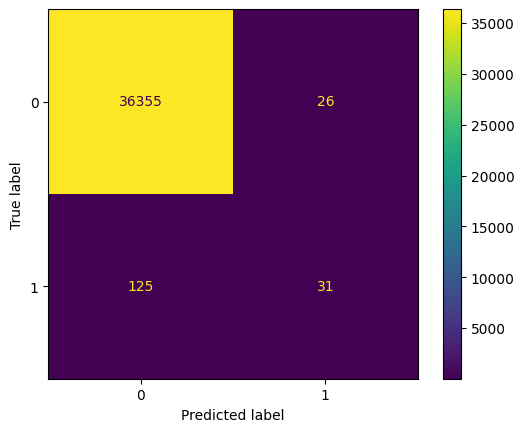

In [210]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

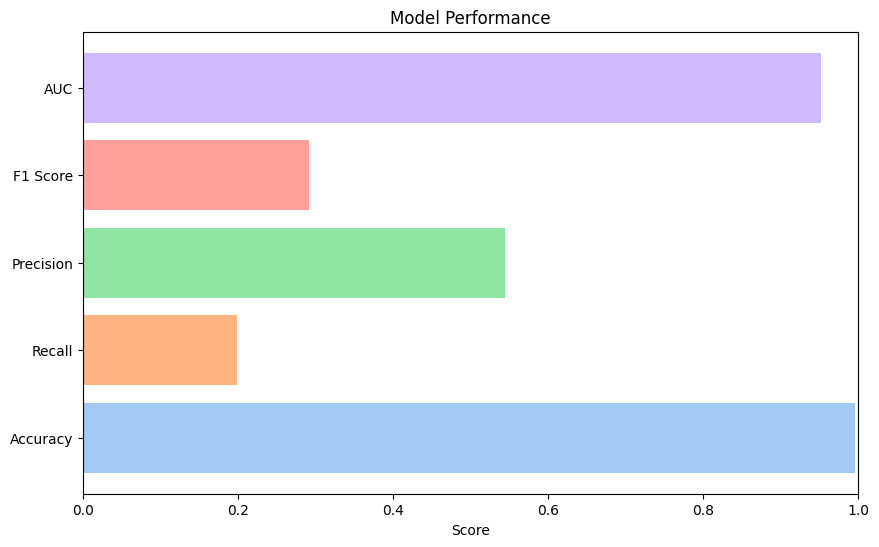

In [211]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [212]:
from sklearn.metrics import average_precision_score, auc

precision2, recall2, threshold = precision_recall_curve(y_test, y_pred_binary)
prauc = auc(precision2, recall2)
print("PRAUC: ", prauc)


PRAUC:  0.3687297491899676


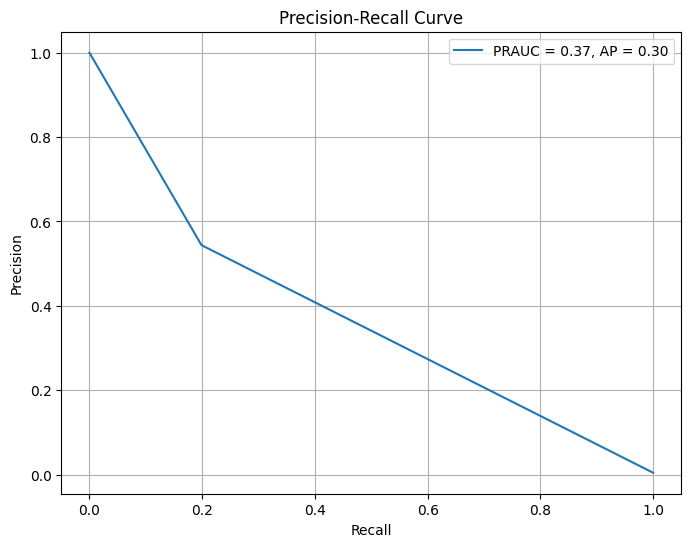

In [213]:
# Calculate the Average Precision (AP) to display in the plot
ap = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall2, precision2, label=f'PRAUC = {prauc:.2f}, AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [214]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
8                     sizelevel        5757
1                         STInt        4811
4                liqnonfinlevel        4769
6                    ni2talevel        4476
10                          m2b        4420
11                        sigma        4143
26               asset_turnover        4134
2                      dtdlevel        4068
19          net_working_capital        4050
15              DTDmedianNonFin        4004
29         receivables_turnover        3877
35           gross_margin_ratio        3835
20                   debt_ratio        3821
18                   cash_ratio        3786
22                 equity_ratio        3718
5                liqnonfintrend        3626
31     working_capital_turnover        3516
23       cashflow_to_debt_ratio        3513
39      interest_coverage_ratio        3465
17                  quick_ratio        3458
7                    ni2tatrend        3440
21         debt_to_equity_ratio 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


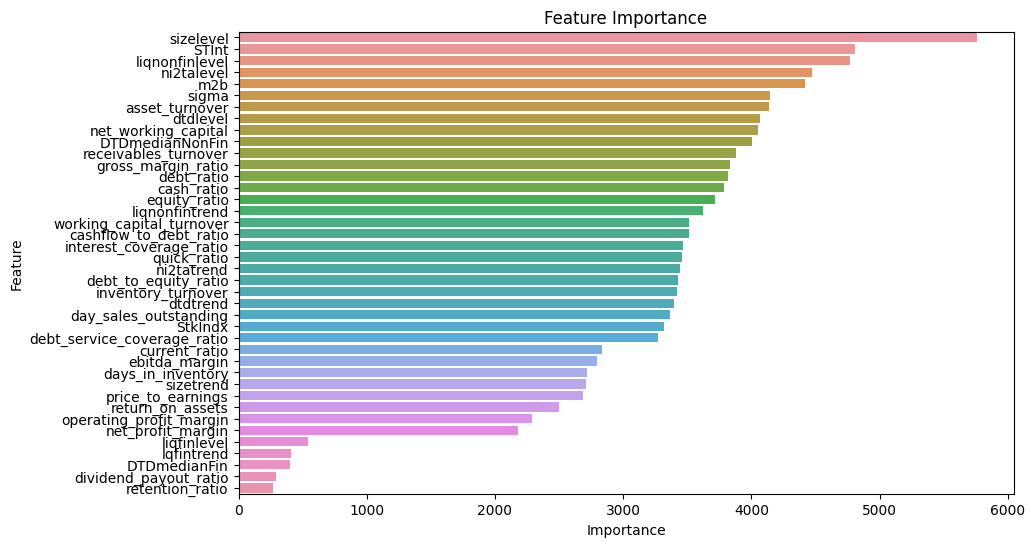

In [194]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

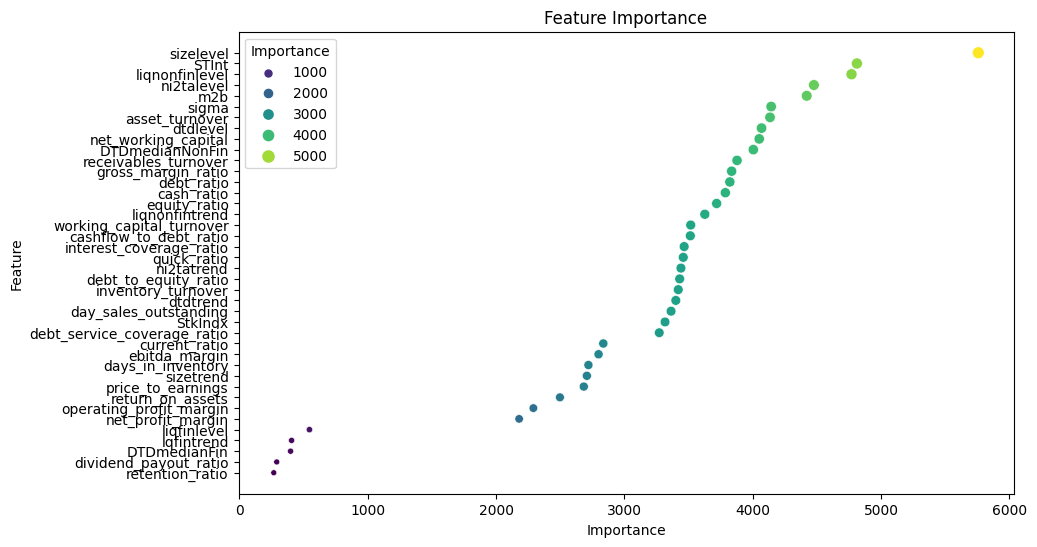

In [195]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

In [196]:
#Precision OPTIMIZED
results = pd.DataFrame({'Recall': [recall], 'Precision': [precision], 'F1 Score': [f1], 'AUC': [auc]})
results.to_csv(path + 'LGB_all_factors_results_recalloptimized.csv', index=False)

best_params_df = pd.DataFrame(best_params, index=[0])
best_params_df.to_csv(path + 'best_params_lgb_allfactors_recalloptimized.csv', index=False)

gbm.save_model(path + 'model_lgb_allfactors_recalloptimized.txt')

Load one model and Plot performances

Accuracy: 0.9958398335933437
Recall: 0.1858974358974359
Precision: 0.5370370370370371
F1 Score: 0.2761904761904762
AUC: 0.9684024275844182


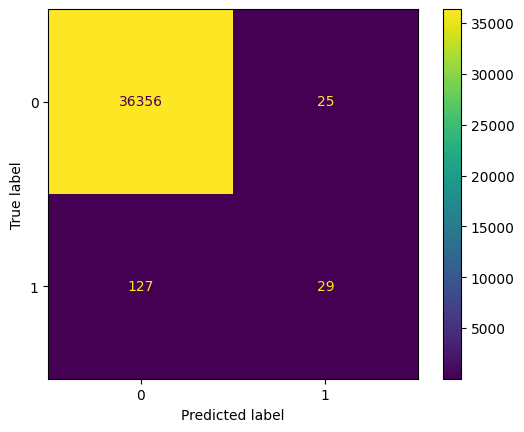

In [197]:
path_to_model = path + "model_lgb_allfactors_aucoptimized.txt"
gbm = lgb.Booster(model_file=path_to_model)

y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)

ConfusionMatrixDisplay(confusion).plot()

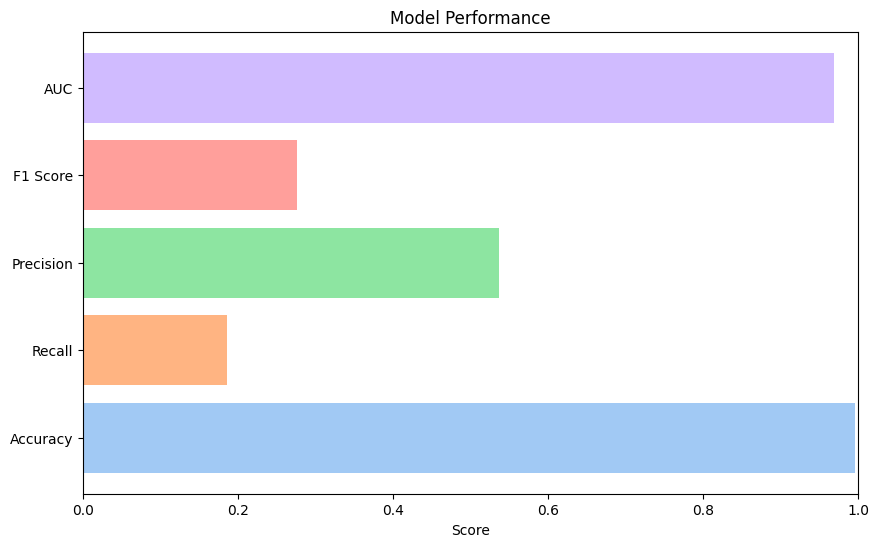

In [198]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [199]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
8                     sizelevel        2692
19          net_working_capital        2651
22                 equity_ratio        2616
1                         STInt        2518
20                   debt_ratio        2504
29         receivables_turnover        2487
4                liqnonfinlevel        2379
26               asset_turnover        2378
17                  quick_ratio        2341
10                          m2b        2236
27           inventory_turnover        2227
30        day_sales_outstanding        2200
35           gross_margin_ratio        2182
6                    ni2talevel        2108
11                        sigma        2091
18                   cash_ratio        2052
31     working_capital_turnover        2036
16                current_ratio        2030
39      interest_coverage_ratio        2029
15              DTDmedianNonFin        2011
23       cashflow_to_debt_ratio        1979
38  debt_service_coverage_ratio 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


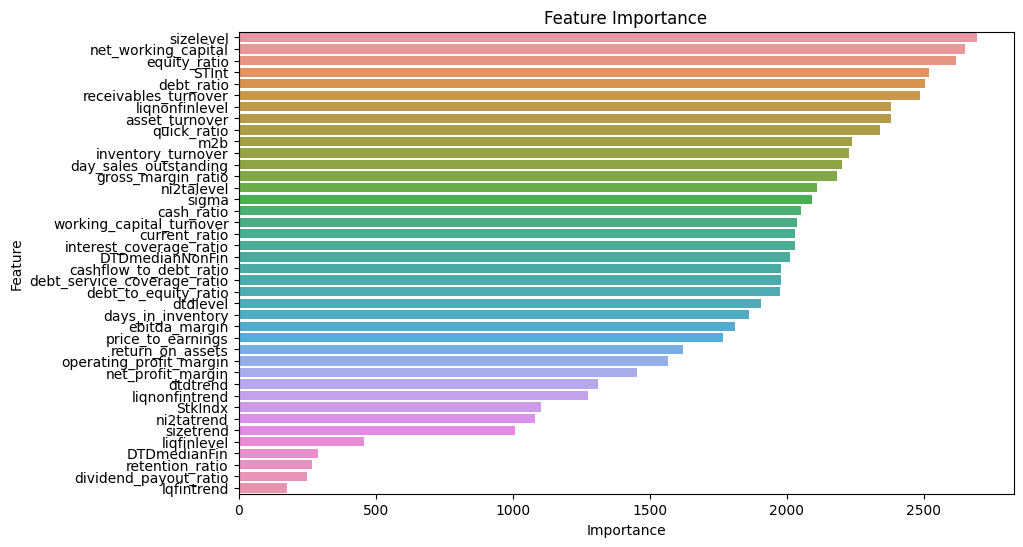

In [200]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

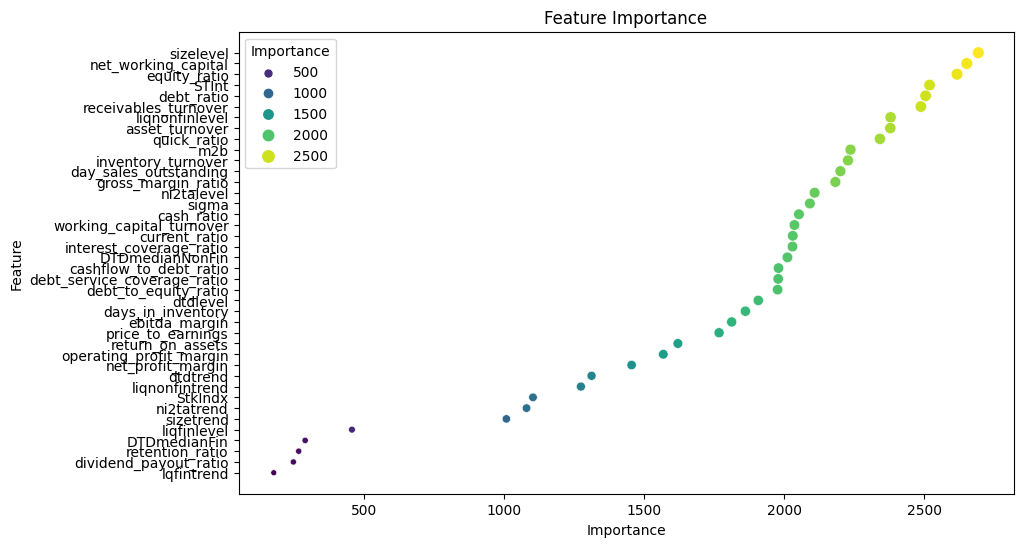

In [201]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

Load 3 models and compare performances


In [205]:
# Load the models
bst1 = lgb.Booster(model_file= path + 'model_lgb_allfactors_aucoptimized.txt')
bst2 = lgb.Booster(model_file= path + 'model_lgb_allfactors_precisionoptimized.txt')
bst3 = lgb.Booster(model_file= path + 'model_lgb_allfactors_recalloptimized.txt')

# Predict the test data
y_pred1 = bst1.predict(x_test)
y_pred2 = bst2.predict(x_test)
y_pred3 = bst3.predict(x_test)

# Calculate the metrics
accuracy1 = accuracy_score(y_test, np.round(y_pred1))
recall1 = recall_score(y_test, np.round(y_pred1))
precision1 = precision_score(y_test, np.round(y_pred1))
f1_1 = f1_score(y_test, np.round(y_pred1))
auc1 = roc_auc_score(y_test, y_pred1)

accuracy2 = accuracy_score(y_test, np.round(y_pred2))
recall2 = recall_score(y_test, np.round(y_pred2))
precision2 = precision_score(y_test, np.round(y_pred2))
f1_2 = f1_score(y_test, np.round(y_pred2))
auc2 = roc_auc_score(y_test, y_pred2)

accuracy3 = accuracy_score(y_test, np.round(y_pred3))
recall3 = recall_score(y_test, np.round(y_pred3))
precision3 = precision_score(y_test, np.round(y_pred3))
f1_3 = f1_score(y_test, np.round(y_pred3))
auc3 = roc_auc_score(y_test, y_pred3)

metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values1 = [accuracy1, recall1, precision1, f1_1, auc1]
values2 = [accuracy2, recall2, precision2, f1_2, auc2]
values3 = [accuracy3, recall3, precision3, f1_3, auc3]

x = np.arange(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, values1, 0.2, color='lightblue', label='ROC AUC optimized')
plt.bar(x, values2, 0.2, color='orange', label='Precision Optimized')
plt.bar(x + 0.2, values3, 0.2, color='lightgreen', label='Recall Optimized')
plt.xticks(x, metrics)
plt.xlabel('Score')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.1)
plt.legend()
plt.show()

importance1 = bst1.feature_importance(importance_type='gain')
importance2 = bst2.feature_importance(importance_type='gain')
importance3 = bst3.feature_importance(importance_type='gain')

# Normalize the feature importance
importance1 = importance1 / sum(importance1)
importance2 = importance2 / sum(importance2)
importance3 = importance3 / sum(importance3)

# # Plot the feature importance
importance_df = pd.DataFrame({'Feature': x_test.columns, 'ROC AUC optimized': importance1, 'Precision Optimized': importance2, 'Recall Optimized': importance3})

importance_df = importance_df.melt('Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', hue='Model', data=importance_df, palette='pastel')
plt.title('Feature Importance Comparison (normalized)')
plt.show()

# Calculate the confusion matrices
confusion1 = confusion_matrix(y_test, np.round(y_pred1))
confusion2 = confusion_matrix(y_test, np.round(y_pred2))
confusion3 = confusion_matrix(y_test, np.round(y_pred3))

# Plot the confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay(confusion1).plot(ax=axes[0], cmap='viridis')
axes[0].set_title('ROC AUC optimized')

ConfusionMatrixDisplay(confusion2).plot(ax=axes[1], cmap='viridis')
axes[1].set_title('Precision Optimized')

ConfusionMatrixDisplay(confusion3).plot(ax=axes[2], cmap='viridis')
axes[2].set_title('Recall Optimized')

plt.tight_layout()
plt.show()

LightGBMError: The number of features in data (40) is not the same as it was in training data (41).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

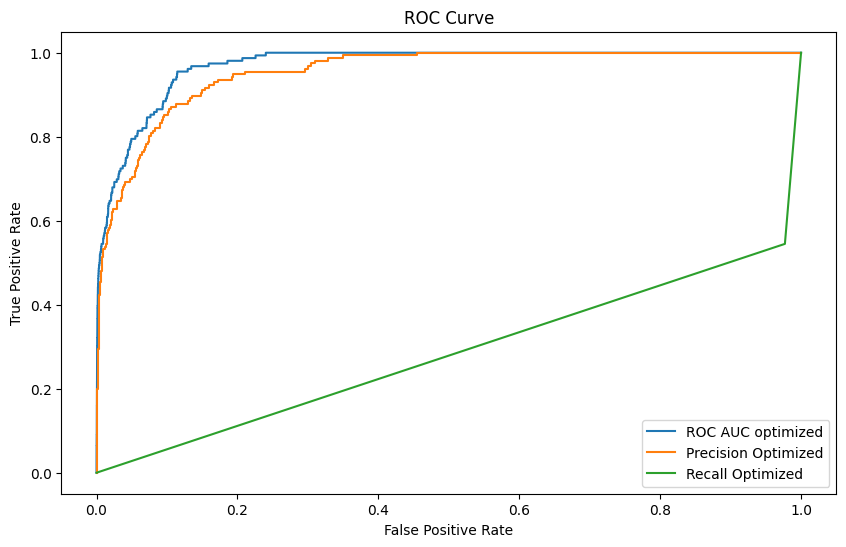

In [ ]:
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
fpr3, tpr3, _ = roc_curve(y_test, y_pred3)

plt.figure(figsize=(10, 6))
plt.plot(fpr1, tpr1, label='ROC AUC optimized')
plt.plot(fpr2, tpr2, label='Precision Optimized')
plt.plot(fpr3, tpr3, label='Recall Optimized')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

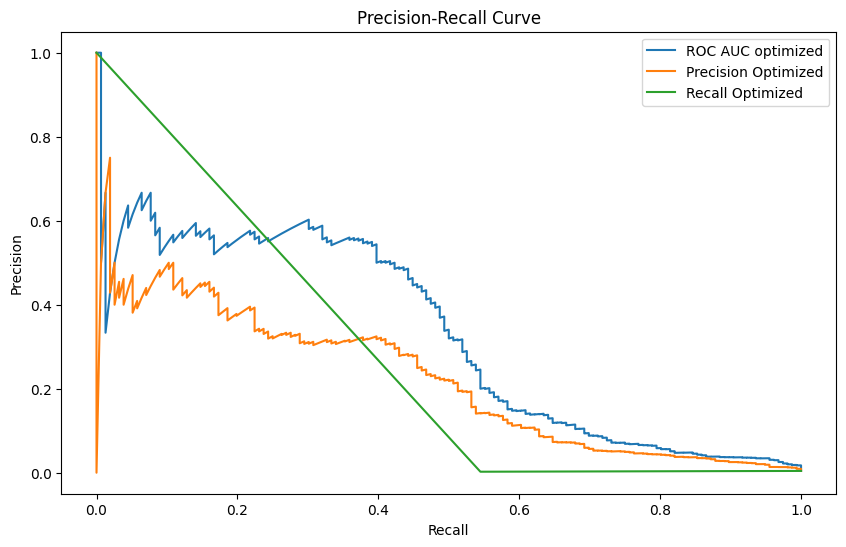

In [ ]:
precision1, recall1, _ = precision_recall_curve(y_test, y_pred1)
precision2, recall2, _ = precision_recall_curve(y_test, y_pred2)
precision3, recall3, _ = precision_recall_curve(y_test, y_pred3)

plt.figure(figsize=(10, 6))
plt.plot(recall1, precision1, label='ROC AUC optimized')
plt.plot(recall2, precision2, label='Precision Optimized')
plt.plot(recall3, precision3, label='Recall Optimized')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Model l
Feature: 0
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 1
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 2
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 3
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 4
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 5
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 6
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 7
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 8
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 9
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7


c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

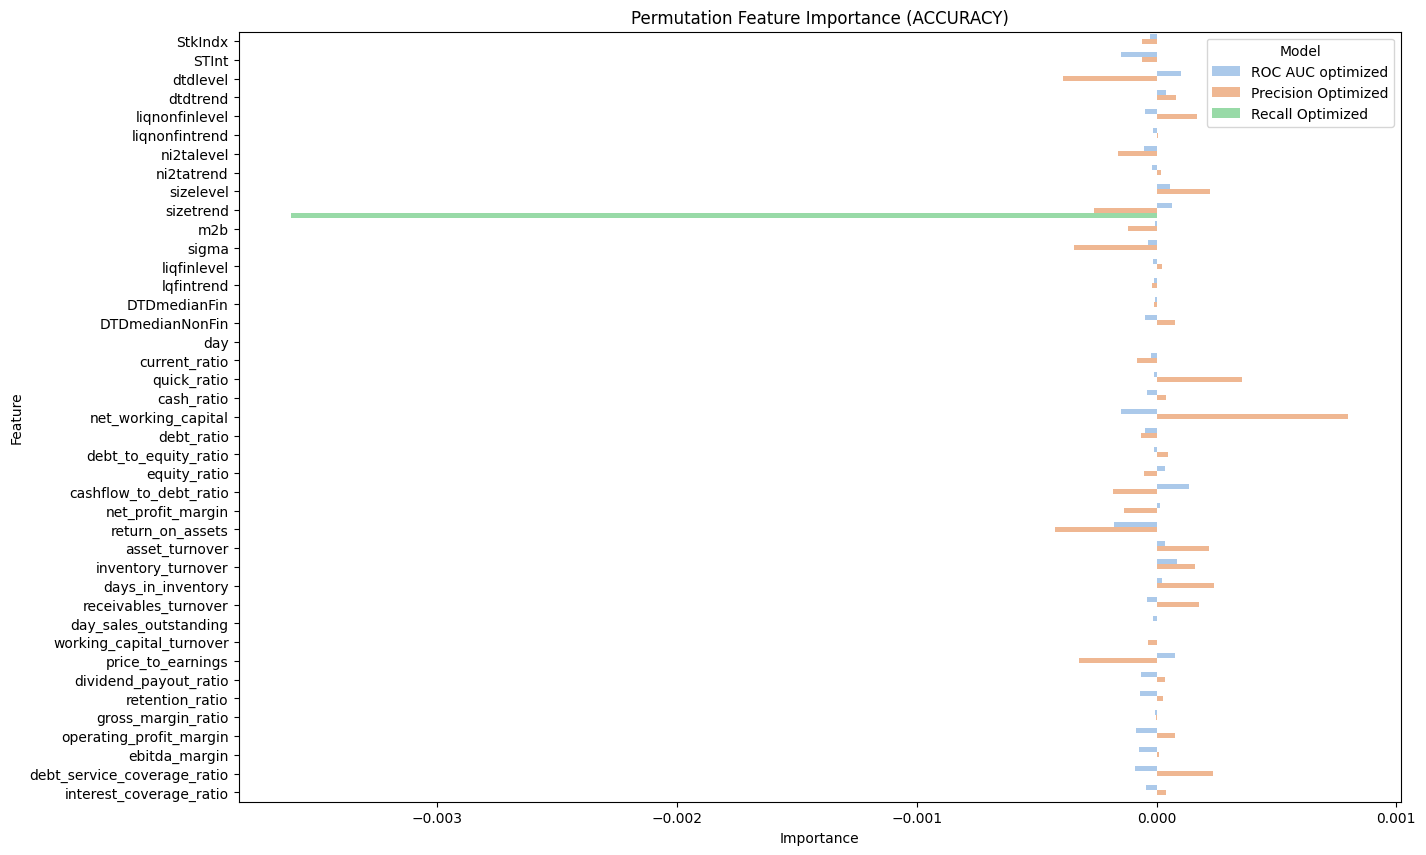

In [ ]:
# BASED ON ACCURACY
def permutation_importance(model, X, y, scoring, n_repeats, random_state):
    baseline_score = scoring(y, np.round(model.predict(X)))
    scores = np.zeros((X.shape[1], n_repeats))
    rng = np.random.RandomState(random_state)
    
    for feature in range(X.shape[1]):
        print("Feature: " + str(feature))
        X_permuted = X.copy()
        for repeat in range(n_repeats):
            print("Repeat:" + str(repeat))
            X_permuted.iloc[:, feature] = rng.permutation(X_permuted.iloc[:, feature])
            score = scoring(y, np.round(model.predict(X_permuted)))
            scores[feature, repeat] = baseline_score - score
    
    return scores

print("Model l")
perm_importance1 = permutation_importance(bst1, x_test, y_test, accuracy_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance2 = permutation_importance(bst2, x_test, y_test, accuracy_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance3 = permutation_importance(bst3, x_test, y_test, accuracy_score, n_repeats=10, random_state=42)

perm_importance_df = pd.DataFrame({'Feature': x_test.columns, 'ROC AUC optimized': np.mean(perm_importance1, axis=1), 'Precision Optimized': np.mean(perm_importance2, axis=1), 'Recall Optimized': np.mean(perm_importance3, axis=1)})

perm_importance_df = perm_importance_df.melt('Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', hue='Model', data=perm_importance_df, palette='pastel')
plt.title('Permutation Feature Importance (ACCURACY)')
plt.show()